# Advanced Lane Finding

## Camera Class

The __LaneCamera__ class implements all camera specific features like calibration, distortion correction and perspective transformation for bird's-eye viewing.

The __ChessBoard__ class is only used during calibration, once calibrated the camera's calibration data can be saved for a simpler startup process

In [1]:
import cv2
import warnings
import numpy as np

# ===========================================
#             CAMERA CLASS
# ===========================================

class LaneCamera(object):
    """
    A camera that can be calibrated and get a birds eye view
    """

    def __init__(self, camera_calibration_file=None, input_shape=(720, 1280)):
        self.calibrated = False
        self.camera_matrix = None
        self.distortion_coeffs = None
        self.input_shape = input_shape
        self.src_pts, self.dest_pts = self._compute_src_dst_pts()
        self.projection_matrix = cv2.getPerspectiveTransform(self.src_pts,
                                                             self.dest_pts)
        self.inverse_projection_matrix = cv2.getPerspectiveTransform(self.dest_pts,
                                                                     self.src_pts)
        if camera_calibration_file:
            self.load_camera_calibration(camera_calibration_file)
    
    def _compute_src_dst_pts(self, margin=(130, 540)):
        mid_x = self.input_shape[1] // 2
        top_y = 2 * self.input_shape[0] // 3
        src = np.float32([
            [mid_x - margin[0], top_y],
            [mid_x + margin[0], top_y],
            [mid_x + margin[1], self.input_shape[0]],
            [mid_x - margin[1], self.input_shape[0]]
        ])
        dest = np.float32([
            [mid_x - margin[1], 0],
            [mid_x + margin[1], 0],
            [mid_x + margin[1], self.input_shape[0]],
            [mid_x - margin[1], self.input_shape[0]]
        ])
        return (src, dest)
    
    def calibrate(self, calibration_imgs, chessboard):
        """Calibrates the camera based on the given ChessBoard object and images
        :param calibration_imgs: List of paths to calibration images
        :param chessboard: A ChessBoard object that defines the chessboard
                           used for calibration
        :type chessboard: ChessBoard object
        :returns: A tuple containing the camera matrix and distortion
                  coefficients
        """
        obj_points = []
        img_points = []

        for img in calibration_imgs:
            img = self.read_img_2_gray(img)
            corners = chessboard.get_corners(img)
            if corners is None:
                # OpenCV returns None if not all corners were in the image
                continue
            else:
                img_points.append(corners)
                obj_points.append(chessboard.obj_points)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            obj_points,
            img_points,
            img.shape[::-1],
            None,
            None)

        self.camera_matrix = mtx
        self.distortion_coeffs = dist
        self.calibrated = True
        return (mtx, dist)

    def set_camera_calibration(self, camera_matrix, distortion_coeffs):
        """ Set the camera calibration if the camera matrix and distortion
            coefficients are already known
            :param camera_matrix: The camera matrix of the camera
            :param distortion_coeffs: The distortion coefficients of the lens
            :type camera_matrix: Numpy array
            :type distortion_coeffs: Numpy array
        """
        self.camera_matrix = camera_matrix
        self.distortion_coeffs = distortion_coeffs
        self.calibrated = True

    def save_camera_calibration(self, path):
        """ Save the camera calibration data to a .npy file
            :param path: Path to save the data to
        """
        assert self.calibrated, \
            "You need to calibrate the camera before saving the calibration"
        np.save(path,
                (self.camera_matrix, self.distortion_coeffs),
                allow_pickle=True)

    def load_camera_calibration(self, path):
        """ Load the camera calibration data from a .npy file
            :param path: Path to the .npy file
        """
        calibration = np.load(path)
        self.camera_matrix, self.distortion_coeffs = calibration
        self.calibrated = True

    def set_birds_eye_view_pts(self, src_pts, dest_pts):
        """ Modify the source and destination points used for the perspective transform
            to get a birds eye view of the road. The transform works by skewing
            the source points to their destination point
            :param src_pts: Source points of the transform
            :param dest_pts: Destination points of the transform
        """
        self.src_pts = src_pts
        self.dest_pts = dest_pts
        self.projection_matrix = cv2.getPerspectiveTransform(self.src_pts,
                                                             self.dest_pts)

    def _undistort(self, img):
        """ Undistort the image using the data found during calibration
        :param img: Image to undistort
        :return: Undistorted Image of the same size
        """
        assert self.calibrated, \
            "The camera should be calibrated with Camera.calibrate()"
        undist = cv2.undistort(img,
                               self.camera_matrix,
                               self.distortion_coeffs,
                               None,
                               self.camera_matrix)
        return undist

    def birds_eye_view(self, img):
        """ Get a birds eye view of the road
        :return: A birds eye view image of the road
        """
        img = self._undistort(img)
        img_y, img_x = img.shape[0:2]
        return cv2.warpPerspective(img, self.projection_matrix, (img_x, img_y), flags=cv2.INTER_LINEAR)

    def inverse_birds_eye_view(self, img):
        """ Does the inverse perspective transform done in the
            birds_eye_view method
            :param img: Input image to unwarp
            :return: Unwarped image
        """
        img_y, img_x = img.shape[0:2]
        return cv2.warpPerspective(img, self.inverse_projection_matrix, (img_x, img_y), flags=cv2.INTER_LINEAR)


# ===========================================
#             CHESSBOARD CLASS
# ===========================================

class ChessBoard(object):
    """ A basic ChessBoard object defining the parameters of the real life
        chessboard used for camera calibration
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.shape = (x, y)
        self.obj_points = self._create_obj_points_matrix()

    def get_corners(self, img):
        """ Get the chessboard corners in an image
        :param img: A numpy image of the chessboard
        :return: Corner coordinates in a numpy array
        :return: None if not all corners were in the image
        """
        got_corners, corners = cv2.findChessboardCorners(img, self.shape, None)

        if not got_corners:
            warnings.warn("Did not find all chessboard corners! \
                          is the chessboard correctly defined?",
                          RuntimeWarning)
            return None

        elif got_corners:
            return corners

    def _create_obj_points_matrix(self):
        """ Creates a generic object point matrix based on the chessboard size
        http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#calibratecamera
        :return: Object points numpy array
        """
        objp = np.zeros((self.y * self.x, 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.x, 0:self.y].T.reshape(-1, 2)
        return objp


### Bird's-eye view example

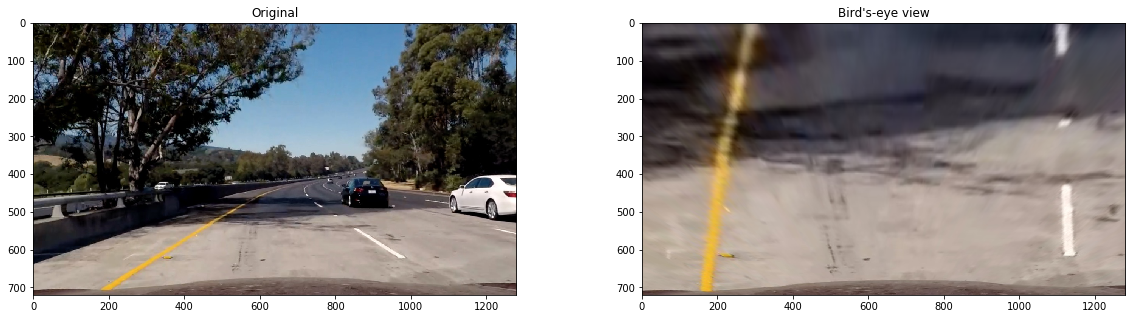

In [2]:
import matplotlib.pyplot as plt

example_camera = LaneCamera(camera_calibration_file="camera_cal/calibration_data.npy")

example = cv2.imread("test_images/test5.jpg")
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

example_undist = example_camera._undistort(example)
view = example_camera.birds_eye_view(example)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1).set_title("Original")
plt.imshow(example_undist)

plt.subplot(1, 2, 2).set_title("Bird's-eye view")
plt.imshow(view)
plt.show()

del example_camera

## Lane Isolation

Creates a binary image where all the detected lane marking pixels are a 1 and the rest is 0. The thresholding is done using the __S channel in HLS color space__ and by thresholding the magitude of the x-direction edge gradients in the image by using a Sobel operator.

In [3]:
def grad_isolation(gray):
    SOBEL_MIN_THRESH = 22
    SOBEL_MAX_THRESH = 105
    
    # X direction edge gradients 
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    abs_sobel = np.absolute(sobel)
    
    # Normalisation
    normed_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Thresholding
    sobel_thresh = np.zeros_like(normed_sobel)
    sobel_thresh[(normed_sobel >= SOBEL_MIN_THRESH) & (normed_sobel < SOBEL_MAX_THRESH)] = 1
    
    return sobel_thresh

def thresholder(img):
    S_CHANNEL_MIN_THRESH = 148
    S_CHANNEL_MAX_THRESH = 255
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # S channel thresholding
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
    sobel_gray = grad_isolation(gray)
    sobel_s = grad_isolation(s_channel)
    
    # Gradient based binary bitmap
    grad = np.zeros_like(sobel_gray)
    grad[(sobel_gray == 1) | (sobel_s == 1)] = 1
    
    # S-Channel of HLS based binary bitmap
    s_thresh = np.zeros_like(s_channel)
    s_thresh[(s_channel >= S_CHANNEL_MIN_THRESH) & (s_channel < S_CHANNEL_MAX_THRESH)] = 1
    
    binary = np.zeros_like(grad)
    binary[(grad == 1) | (s_thresh == 1)] = 1
    return binary

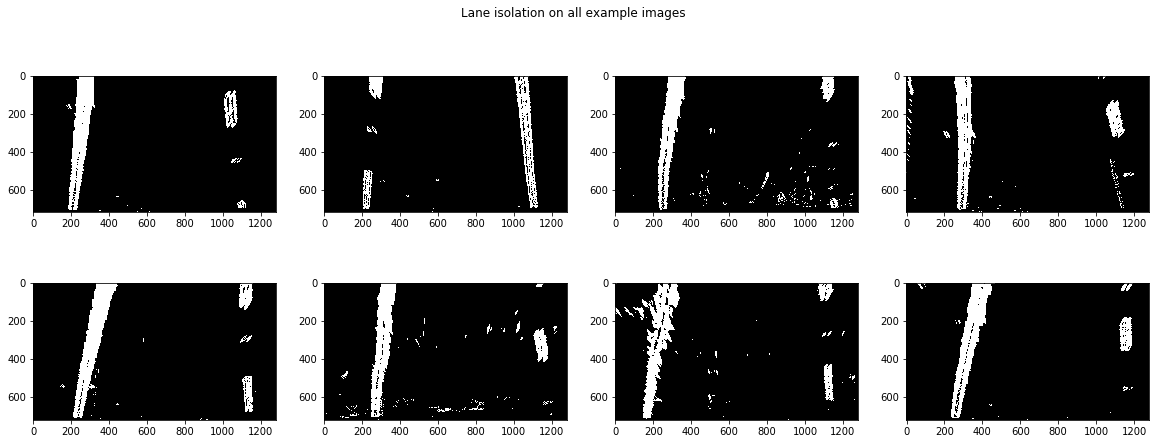

In [4]:
from glob import glob

test_imgs = glob("test_images/*.jpg")

test_camera = LaneCamera(camera_calibration_file="camera_cal/calibration_data.npy")

plt.figure(figsize=(20, 7)).suptitle("Lane isolation on all example images")
for idx, img in enumerate(test_imgs):
    plt.subplot(2, len(test_imgs)//2, idx+1)
    img = cv2.imread(img)
    line = thresholder(img)
    view = test_camera.birds_eye_view(line)
    plt.imshow(view, cmap="gray")
plt.show()

## Lane Detection & Curvature + Offset

In [5]:
# Define pixel to meter conversion constants
Y_M_PER_PIX = 30/720
X_M_PER_PIX = 3.7/700
LANE_WIDTH_IN_M = 3.7

The lane is defined by a second degree polynomial:

$$ f\left(y\right)=Ay^2+By+C $$

And its radius of curvature by:

$$ R_{curve}=\frac{\left[1+\left(\frac{dy}{dx}\right)^2\right]^{\frac{3}{2}}}{\left|\frac{d^2x}{dy^2}\right|} $$
$$ \quad where \quad
\frac{dx}{dy}=2Ay+B
\quad  and  \quad
\frac{d^2x}{dy^2}=2A $$

therefore the lane curvature at a selected y value will be equal to:

$$ R_{curve}=\frac{\left(1+\left(2Ay+B\right)^2\right)^{\frac{3}{2}}}{\ \left| 2A \right|} $$

In [19]:
def curvature(y, x, y_eval):
    poly = np.polyfit((y * Y_M_PER_PIX), (x * X_M_PER_PIX), 2)
    curve = ((1 + (2*poly[0]*(y_eval*Y_M_PER_PIX) + poly[1])**2)**1.5) / np.absolute(2*poly[0])
    return curve

def center_offset(left_x, right_x, x_img_midpoint):
    width_px = np.absolute(left_x - right_x)
    lane_center = (left_x + right_x) // 2
    offset_px = lane_center - x_img_midpoint
    return LANE_WIDTH_IN_M * (offset_px/width_px)

In [20]:
class Lane(object):
    def __init__(self,
                 y, 
                 poly_left_x, 
                 poly_right_x, 
                 vis,
                 lane_detections,
                 left_curvature,
                 right_curvature,
                 offset):
        self.y = y
        self.poly_left_x = poly_left_x
        self.poly_right_x = poly_right_x
        self.vis = vis
        self.lane_detections = lane_detections
        self.left_curvature = left_curvature
        self.right_curvature = right_curvature
        self.offset = offset

To find a lane, we first start at the bottom of the image and detect lane starts through histogram peaks. We then slide a window upwards and shift it so that it's centered on the lane lines.

In [14]:
class LaneFinder(object):
    def __init__(self, in_video_mode=True, input_shape=(720, 1280, 3)):
        self.in_video_mode = in_video_mode
        self.lane_stack_size = 7
        self.found_first_lane = False
        self.input_shape = input_shape
        self.num_win = 10
        self.win_width = 80
        self.win_height = input_shape[0] // self.num_win
        self.recenter_threshold = self.win_width * 2
        self.midpoint = self.input_shape[0] // 2
        self.prev_left_fits = []
        self.prev_right_fits = []
        
    def find(self, bird_view_binary):
        lane = None
        if len(self.prev_left_fits) > self.lane_stack_size:
            self.prev_left_fits.pop()
        
        if len(self.prev_right_fits) > self.lane_stack_size:
            self.prev_right_fits.pop()
        
        if (self.found_first_lane == True and self.in_video_mode):
            lane = self._next_frame_search(bird_view_binary)
        else:
            lane = self._sliding_window_search(bird_view_binary)
        return lane
    
    def _sliding_window_search(self, bird_view_binary):
        # keep an image copy for visualisation purposes
        visual = bird_view_binary.copy()
        visual[visual > 0] = 255
        visual = np.dstack([visual, visual, visual])

        hist = np.sum(bird_view_binary[bird_view_binary.shape[0] // 2:, :], axis=0)
        
        left_lane, right_lane = [], []

        right_x = np.argmax(hist[self.midpoint:]) + self.midpoint
        left_x = np.argmax(hist[:self.midpoint])

        # Get positive detection image pixel positions
        non_zeros = bird_view_binary.nonzero()
        non_zeros_y = np.array(non_zeros[0])
        non_zeros_x = np.array(non_zeros[1])

        for window in range(self.num_win):
            # Compute current window bounding box in the image
            win = {
                "min_y": bird_view_binary.shape[0] - (window + 1) * self.win_height,
                "max_y": bird_view_binary.shape[0] - (window * self.win_height),
                "min_left_x": max(0, left_x - self.win_width),
                "max_left_x": left_x + self.win_width,
                "min_right_x": right_x - self.win_width,
                "max_right_x": min(bird_view_binary.shape[1] - 1, right_x + self.win_width)
            }
            # Draw visualisation
            cv2.rectangle(visual,
                          (win["min_left_x"], win["max_y"]), 
                          (win["max_left_x"], win["min_y"]), 
                          (255, 255, 0), 2)
            cv2.rectangle(visual,
                          (win["min_right_x"], win["max_y"]), 
                          (win["max_right_x"], win["min_y"]), 
                          (255, 255, 0), 2)

            # Isolated detected left and right lane pixel positions
            left = (
                (non_zeros_y >= win["min_y"])&
                (non_zeros_y <= win["max_y"])&
                (non_zeros_x >= win["min_left_x"])&
                (non_zeros_x <= win["max_left_x"])
            ).nonzero()[0]

            right = (
                (non_zeros_y >= win["min_y"])&
                (non_zeros_y <= win["max_y"])&
                (non_zeros_x >= win["min_right_x"])&
                (non_zeros_x <= win["max_right_x"])
            ).nonzero()[0]

            # Add detected pixels to lane lists
            left_lane.append(left)
            right_lane.append(right)

            # Recenter windows if needed
            if len(left) > self.recenter_threshold:
                left_x = int(np.mean(non_zeros_x[left]))

            if len(right) > self.recenter_threshold:
                right_x = int(np.mean(non_zeros_x[right]))

        # Make arrays contiguous
        left_lane = np.concatenate(left_lane)
        right_lane = np.concatenate(right_lane)

        # Extract our lane pixel coordinates
        left_x = non_zeros_x[left_lane]
        left_y = non_zeros_y[left_lane]
        right_x = non_zeros_x[right_lane]
        right_y = non_zeros_y[right_lane]

        # Color code the left and right lane pixel selection
        visual[left_y, left_x] = [0, 0, 200]
        visual[right_y, right_x] = [200, 0, 0]

        # Fit each lane pixels to a polynomial
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
        self.prev_left_fits.insert(0, left_fit)
        self.prev_right_fits.insert(0, right_fit)
        
        # Generate points for shape filling the lane polygon
        poly_y = np.linspace(0, bird_view_binary.shape[0] - 1, bird_view_binary.shape[0])
        poly_left_x = left_fit[0]*poly_y**2 + left_fit[1]*poly_y + left_fit[2]
        poly_right_x = right_fit[0]*poly_y**2 + right_fit[1]*poly_y + right_fit[2]

        # Calculate curvature for each lane (in meters)
        left_curve = curvature(poly_y, poly_left_x, np.max(poly_y))
        right_curve = curvature(poly_y, poly_right_x, np.max(poly_y))

        lane_detections = visual.copy()
        lane_detections[lane_detections == 255] = 0

        # Calculate car offset
        offset = center_offset(poly_left_x[-1], poly_right_x[-1], bird_view_binary.shape[1]//2)
        self.found_first_lane = True
        return Lane(poly_y, poly_left_x, poly_right_x, visual, lane_detections, left_curve, right_curve, offset)

    def _next_frame_search(self, bird_view_binary):
        non_zero = bird_view_binary.nonzero()
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])
        margin = 100
        
        prev_left_fit = self.prev_left_fits[0]
        prev_right_fit = self.prev_right_fits[0]
        
        left_lane = ((non_zero_x > (prev_left_fit[0]*(non_zero_y**2) + prev_left_fit[1]*non_zero_y + 
prev_left_fit[2] - margin)) & (non_zero_x < (prev_left_fit[0]*(non_zero_y**2) + 
prev_left_fit[1]* non_zero_y + prev_left_fit[2] + margin))) 
        right_lane = ((non_zero_x > (prev_right_fit[0]*(non_zero_y**2) + prev_right_fit[1]*non_zero_y + 
prev_right_fit[2] - margin)) & (non_zero_x < (prev_right_fit[0]*(non_zero_y**2) + 
prev_right_fit[1]*non_zero_y + prev_right_fit[2] + margin)))  
        
        left_x = non_zero_x[left_lane]
        left_y = non_zero_y[left_lane]
        right_x = non_zero_x[right_lane]
        right_y = non_zero_y[right_lane]
        
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
        self.prev_right_fits.insert(0, right_fit)
        self.prev_left_fits.insert(0, left_fit)
        
        plot_y = np.linspace(0, bird_view_binary.shape[0] - 1, bird_view_binary.shape[0])
        
        left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
        right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
        visual = np.zeros(bird_view_binary.shape)
        
        left_curve = curvature(plot_y, left_fit_x, np.max(plot_y))
        right_curve = curvature(plot_y, right_fit_x, np.max(plot_y))
        
        offset = center_offset(left_fit_x[-1], right_fit_x[-1], bird_view_binary.shape[1]//2)
        return Lane(plot_y, left_fit_x, right_fit_x, visual, bird_view_binary, left_curve, right_curve, offset)
    
    def overlay(self, img, lane, fill_color=(0, 255, 0)):
        # Setup our vertices matrix in order to fill out a polygon
        left_verts = np.array([np.vstack([lane.poly_left_x, lane.y]).T])
        right_verts = np.array([np.flipud(np.vstack([lane.poly_right_x, lane.y]).T)])

        # Final vertices matrix going in an anticlockwise direction
        vertices = np.hstack((left_verts, right_verts))

        # Fill the polygon
        fill = np.zeros_like(img)
        cv2.fillPoly(fill,
                     np.int_([vertices]),
                     fill_color)
        # Blend/Add it to the lane detections image
        return fill


    def data_info(self, overlayed_img, lane):
        cv2.putText(overlayed_img, "Left curvature {:.2f}m".format(lane.left_curvature), 
                    (40, 40), 
                    cv2.FONT_HERSHEY_DUPLEX,
                    1,
                    (255, 255, 255))

        cv2.putText(overlayed_img, "Right curvature {:.2f}m".format(lane.right_curvature), 
                    (40, 80), 
                    cv2.FONT_HERSHEY_DUPLEX,
                    1,
                    (255, 255, 255))

        cv2.putText(overlayed_img, "Offset from center {:.2f}m".format(lane.offset), 
                    (40, 120), 
                    cv2.FONT_HERSHEY_DUPLEX,
                    1,
                    (255, 255, 255))

        return overlayed_img

### Image pipeline example

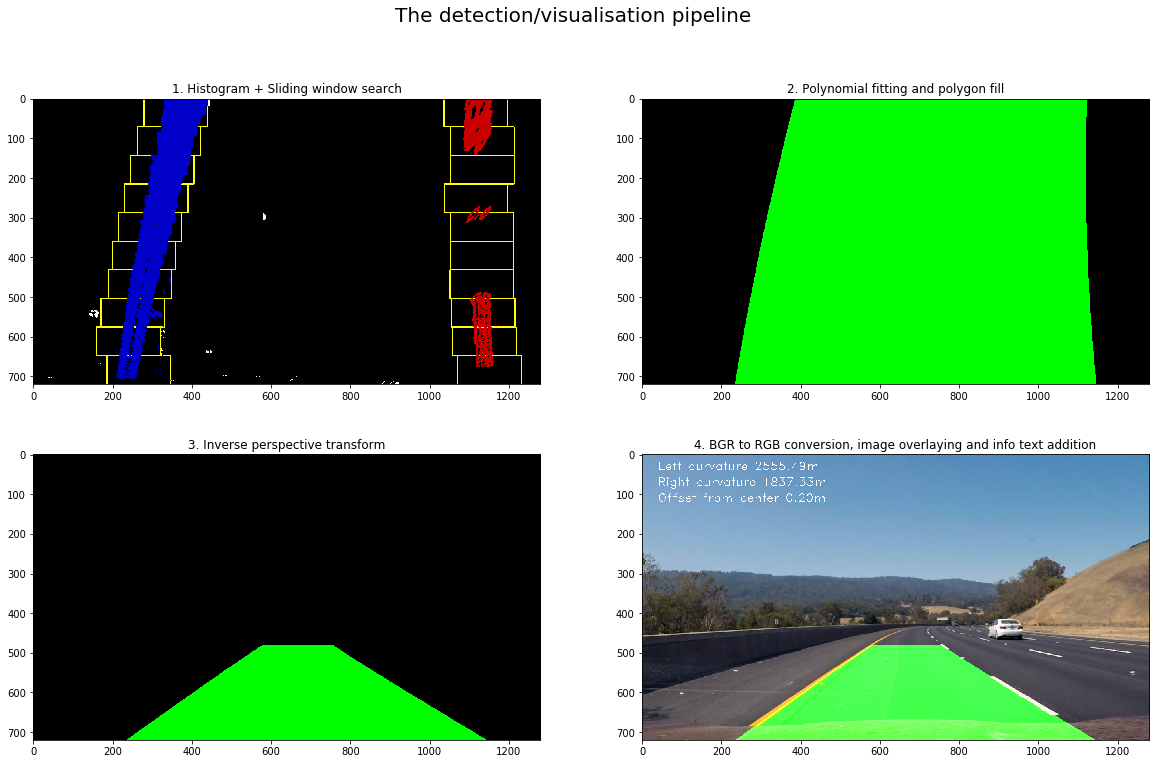

In [18]:
example_camera = LaneCamera(camera_calibration_file="camera_cal/calibration_data.npy")
example = cv2.imread("test_images/test3.jpg")
binary = thresholder(example)
view = example_camera.birds_eye_view(binary)
lane_finder = LaneFinder(in_video_mode=False)
lane = lane_finder.find(view)

plt.figure(figsize=(20, 12)).suptitle("The detection/visualisation pipeline", size=20)

plt.subplot(2, 2, 1).set_title("1. Histogram + Sliding window search")
plt.imshow(lane.vis)

plt.subplot(2, 2, 2).set_title("2. Polynomial fitting and polygon fill")
hud = lane_finder.overlay(example, lane)
plt.imshow(hud)

plt.subplot(2, 2, 3).set_title("3. Inverse perspective transform")
hud_inv = test_camera.inverse_birds_eye_view(hud)
plt.imshow(hud_inv)

plt.subplot(2, 2, 4).set_title("4. BGR to RGB conversion, image overlaying and info text addition")
final_view = cv2.cvtColor(cv2.addWeighted(example, 1, hud_inv, 1, 0), cv2.COLOR_BGR2RGB)
final_view = lane_finder.data_info(final_view, lane)
plt.imshow(final_view)
plt.show()

del example_camera

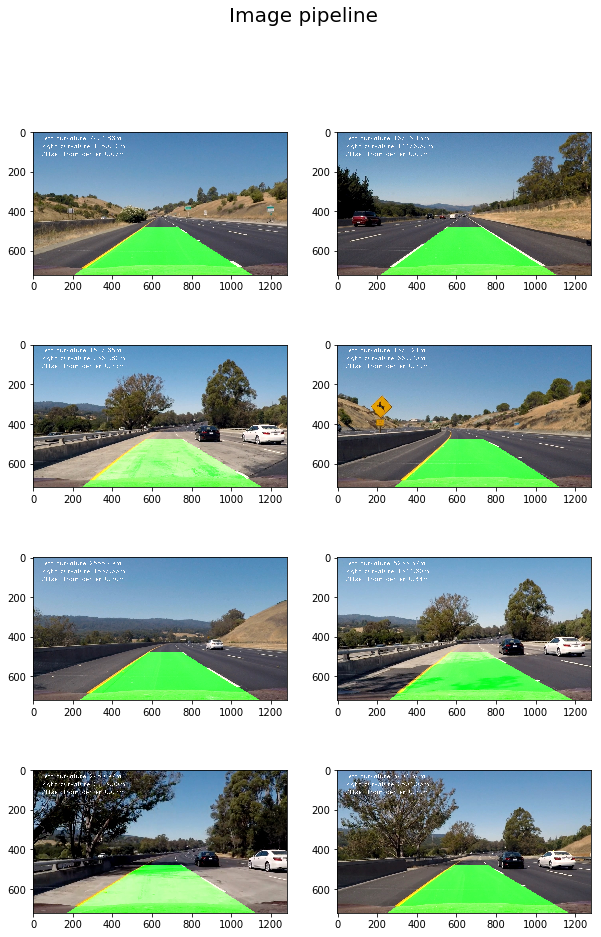

In [16]:
test_imgs = glob("test_images/*.jpg")

example_camera = LaneCamera(camera_calibration_file="camera_cal/calibration_data.npy")

plt.figure(figsize=(10, 15)).suptitle("Image pipeline", size=20)
for idx, img in enumerate(test_imgs):
    plt.subplot(4, len(test_imgs)//4, idx+1)
    img = cv2.imread(img)
    binary = thresholder(img)
    view = example_camera.birds_eye_view(binary)
    lane = lane_finder.find(view)
    hud = lane_finder.overlay(img, lane)
    hud_inv = test_camera.inverse_birds_eye_view(hud)
    final_view = cv2.cvtColor(cv2.addWeighted(img, 1, hud_inv, 1, 0), cv2.COLOR_BGR2RGB)
    final_view = lane_finder.data_info(final_view, lane)
    plt.imshow(final_view)
plt.show()

In [17]:
camera = LaneCamera(camera_calibration_file="camera_cal/calibration_data.npy")
video_lane_finder = LaneFinder()

def video_pipeline(image):
    binary = thresholder(image)
    view = camera.birds_eye_view(binary)
    lane = video_lane_finder.find(view)
    display = video_lane_finder.overlay(image, lane)
    display = camera.inverse_birds_eye_view(display)
    final_view = cv2.addWeighted(image, 1, display, 1, 0)
    final_view = video_lane_finder.data_info(final_view, lane)
    return final_view

In [21]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip

video = VideoFileClip("./test_videos/project_video.mp4")
video = video.fl_image(video_pipeline) 

%time video.write_videofile("./fixed_output_project_video.mp4", audio=False)

[MoviePy] >>>> Building video ./fixed_output_project_video.mp4
[MoviePy] Writing video ./fixed_output_project_video.mp4


100%|█████████▉| 1260/1261 [08:54<00:00,  2.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./fixed_output_project_video.mp4 

CPU times: user 10min 44s, sys: 44.8 s, total: 11min 28s
Wall time: 8min 56s


In [22]:
HTML("""
    <h1 style="font-family: sans-serif; padding: 20px 0; text-align: center">Output project video</h1>
    <div style="width: 100%">
        <video style="width: inherit" controls autoplay loop src="fixed_output_project_video.mp4"/>
    </div>
""")